In [41]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F


In [42]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale mask
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask


In [43]:
image_dir = "/Users/mehdiarat/Downloads/Dataset_BUSI_with_GT 2"  # Verilerin bulunduğu ana klasör
categories = ["benign", "malignant"]

image_paths = []
mask_paths = []

for category in categories:
    category_image_dir = os.path.join(image_dir, category)
    for file_name in os.listdir(category_image_dir):
        if "mask" in file_name:
            continue
        image_paths.append(os.path.join(category_image_dir, file_name))
        mask_name = file_name.replace(".png", "_mask.png")
        mask_paths.append(os.path.join(category_image_dir, mask_name))

# Verileri eğitim ve test olarak böl
train_images, test_images, train_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

import torchvision.transforms as transforms

# Sabit bir boyuta yeniden boyutlandırmak için transform tanımlama
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Tüm görüntüleri 256x256 boyutuna getir
    transforms.ToTensor(),          # Görüntüyü tensöre dönüştür
])

# Dataset sınıfını oluştururken bu transform'u kullanın
train_dataset = SegmentationDataset(train_images, train_masks, transform=transform)
test_dataset = SegmentationDataset(test_images, test_masks, transform=transform)

# DataLoader ile veri yükleyicileri oluşturun
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

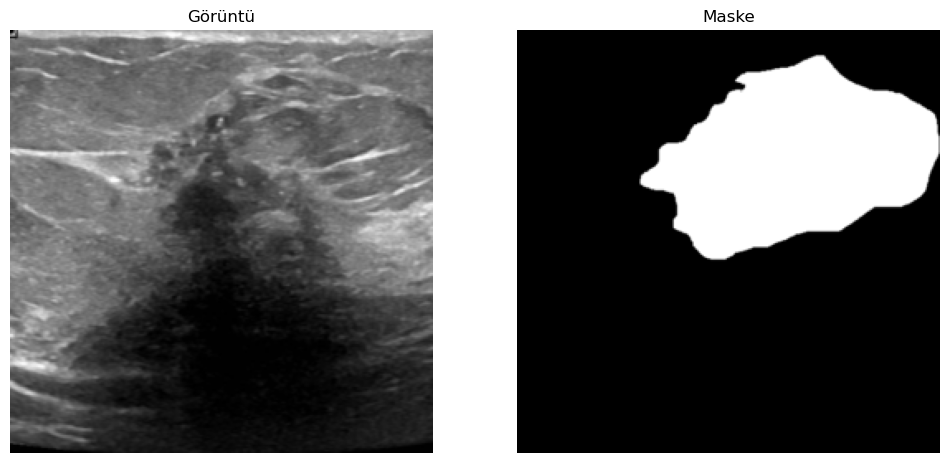

In [44]:
# Eğitim veri setinden rastgele bir örnek seçelim
sample_idx = random.randint(0, len(train_dataset) - 1)
sample_image, sample_mask = train_dataset[sample_idx]

# Görüntü ve maskeyi görselleştirelim
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Görüntüyü görselleştir
ax[0].imshow(sample_image.permute(1, 2, 0))  # PyTorch (C, H, W) formatında olduğu için permute yapıyoruz
ax[0].set_title('Görüntü')
ax[0].axis('off')

# Maskeyi görselleştir
ax[1].imshow(sample_mask.squeeze(), cmap='gray')
ax[1].set_title('Maske')
ax[1].axis('off')

plt.show()

In [45]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, init_features=16, dropout_rate=0.1):
        super(UNet, self).__init__()
        
        features = init_features
        self.encoder1 = ConvBlock(in_channels, features)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.encoder2 = ConvBlock(features, features * 2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.encoder3 = ConvBlock(features * 2, features * 4)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.encoder4 = ConvBlock(features * 4, features * 8)
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        self.bottleneck = ConvBlock(features * 8, features * 16)
        
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = ConvBlock(features * 16, features * 8)
        self.dropout5 = nn.Dropout(dropout_rate)
        
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = ConvBlock(features * 8, features * 4)
        self.dropout6 = nn.Dropout(dropout_rate)
        
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = ConvBlock(features * 4, features * 2)
        self.dropout7 = nn.Dropout(dropout_rate)
        
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = ConvBlock(features * 2, features)
        self.dropout8 = nn.Dropout(dropout_rate)
        
        self.conv_last = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pool = self.dropout1(self.pool1(enc1))
        
        enc2 = self.encoder2(enc1_pool)
        enc2_pool = self.dropout2(self.pool2(enc2))
        
        enc3 = self.encoder3(enc2_pool)
        enc3_pool = self.dropout3(self.pool3(enc3))
        
        enc4 = self.encoder4(enc3_pool)
        enc4_pool = self.dropout4(self.pool4(enc4))
        
        bottleneck = self.bottleneck(enc4_pool)
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dropout5(self.decoder4(dec4))
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dropout6(self.decoder3(dec3))
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dropout7(self.decoder2(dec2))
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dropout8(self.decoder1(dec1))
        
        return torch.sigmoid(self.conv_last(dec1))

# Örnek kullanım:
# model = UNet(in_channels=3, out_channels=1)

In [46]:
def iou_score(pred, target, smooth=1e-6):
    pred = pred.bool()
    target = target.bool()
    
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [47]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

In [48]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")


In [49]:
# Modeli tanımlama ve optimizasyon
model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

# Erken durdurma için değişkenler
best_val_loss = float('inf')
patience = 15
early_stopping_counter = 0

# Eğitim ve Doğrulama Döngüleri
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        # İleri yayılım (Forward pass)
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # Kayıp hesaplama
        loss = criterion(outputs, masks)
        train_loss += loss.item()
        
        # Geri yayılım ve optimizasyon
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return train_loss / len(train_loader)

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    return val_loss / len(val_loader)
 

In [50]:
num_epochs = 75

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate_one_epoch(model, test_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    
    # Erken durdurma kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')  # Modelin en iyi halini kaydet
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Erken durdurma: İyileşme gözlenmedi, eğitim durduruluyor.")
        model.load_state_dict(torch.load('best_model.pth'))  # En iyi modeli geri yükle
        break

Epoch 1/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  7.76it/s]


Train Loss: 0.9090 | Validation Loss: 0.9118
Epoch 2/75


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00,  9.04it/s]


Train Loss: 0.8900 | Validation Loss: 0.8868
Epoch 3/75


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00,  9.09it/s]


Train Loss: 0.8706 | Validation Loss: 0.8762
Epoch 4/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.90it/s]


Train Loss: 0.8592 | Validation Loss: 0.8631
Epoch 5/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.84it/s]


Train Loss: 0.8543 | Validation Loss: 0.8694
Epoch 6/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.82it/s]


Train Loss: 0.8492 | Validation Loss: 0.8592
Epoch 7/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.83it/s]


Train Loss: 0.8459 | Validation Loss: 0.8572
Epoch 8/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.56it/s]


Train Loss: 0.8413 | Validation Loss: 0.8502
Epoch 9/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.67it/s]


Train Loss: 0.8368 | Validation Loss: 0.8525
Epoch 10/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.60it/s]


Train Loss: 0.8339 | Validation Loss: 0.8469
Epoch 11/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.72it/s]


Train Loss: 0.8298 | Validation Loss: 0.8445
Epoch 12/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.82it/s]


Train Loss: 0.8261 | Validation Loss: 0.8357
Epoch 13/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.65it/s]


Train Loss: 0.8224 | Validation Loss: 0.8332
Epoch 14/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.72it/s]


Train Loss: 0.8194 | Validation Loss: 0.8342
Epoch 15/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.69it/s]


Train Loss: 0.8157 | Validation Loss: 0.8429
Epoch 16/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.58it/s]


Train Loss: 0.8115 | Validation Loss: 0.8208
Epoch 17/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.73it/s]


Train Loss: 0.8090 | Validation Loss: 0.8167
Epoch 18/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.57it/s]


Train Loss: 0.8053 | Validation Loss: 0.8181
Epoch 19/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.72it/s]


Train Loss: 0.8017 | Validation Loss: 0.8179
Epoch 20/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.62it/s]


Train Loss: 0.7985 | Validation Loss: 0.8195
Epoch 21/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.80it/s]


Train Loss: 0.7948 | Validation Loss: 0.8049
Epoch 22/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.68it/s]


Train Loss: 0.7913 | Validation Loss: 0.8023
Epoch 23/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.50it/s]


Train Loss: 0.7893 | Validation Loss: 0.8052
Epoch 24/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.69it/s]


Train Loss: 0.7868 | Validation Loss: 0.8057
Epoch 25/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.68it/s]


Train Loss: 0.7825 | Validation Loss: 0.7937
Epoch 26/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.90it/s]


Train Loss: 0.7800 | Validation Loss: 0.7942
Epoch 27/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.81it/s]


Train Loss: 0.7769 | Validation Loss: 0.7894
Epoch 28/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.88it/s]


Train Loss: 0.7741 | Validation Loss: 0.7967
Epoch 29/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.63it/s]


Train Loss: 0.7714 | Validation Loss: 0.7836
Epoch 30/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.62it/s]


Train Loss: 0.7680 | Validation Loss: 0.7843
Epoch 31/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.58it/s]


Train Loss: 0.7666 | Validation Loss: 0.7761
Epoch 32/75


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00,  9.15it/s]


Train Loss: 0.7632 | Validation Loss: 0.7799
Epoch 33/75


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00,  9.11it/s]


Train Loss: 0.7612 | Validation Loss: 0.7816
Epoch 34/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.67it/s]


Train Loss: 0.7586 | Validation Loss: 0.7706
Epoch 35/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.73it/s]


Train Loss: 0.7561 | Validation Loss: 0.7662
Epoch 36/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.64it/s]


Train Loss: 0.7531 | Validation Loss: 0.7654
Epoch 37/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.68it/s]


Train Loss: 0.7511 | Validation Loss: 0.7668
Epoch 38/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.69it/s]


Train Loss: 0.7480 | Validation Loss: 0.7650
Epoch 39/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.74it/s]


Train Loss: 0.7460 | Validation Loss: 0.7615
Epoch 40/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.72it/s]


Train Loss: 0.7435 | Validation Loss: 0.7561
Epoch 41/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.60it/s]


Train Loss: 0.7417 | Validation Loss: 0.7554
Epoch 42/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.63it/s]


Train Loss: 0.7396 | Validation Loss: 0.7573
Epoch 43/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.48it/s]


Train Loss: 0.7379 | Validation Loss: 0.7558
Epoch 44/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.66it/s]


Train Loss: 0.7355 | Validation Loss: 0.7604
Epoch 45/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.72it/s]


Train Loss: 0.7345 | Validation Loss: 0.7448
Epoch 46/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.63it/s]


Train Loss: 0.7325 | Validation Loss: 0.7487
Epoch 47/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.70it/s]


Train Loss: 0.7298 | Validation Loss: 0.7434
Epoch 48/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.90it/s]


Train Loss: 0.7284 | Validation Loss: 0.7435
Epoch 49/75


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00,  9.01it/s]


Train Loss: 0.7266 | Validation Loss: 0.7426
Epoch 50/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.85it/s]


Train Loss: 0.7263 | Validation Loss: 0.7396
Epoch 51/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.68it/s]


Train Loss: 0.7238 | Validation Loss: 0.7379
Epoch 52/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.86it/s]


Train Loss: 0.7222 | Validation Loss: 0.7383
Epoch 53/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.67it/s]


Train Loss: 0.7204 | Validation Loss: 0.7410
Epoch 54/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.83it/s]


Train Loss: 0.7181 | Validation Loss: 0.7324
Epoch 55/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.72it/s]


Train Loss: 0.7167 | Validation Loss: 0.7315
Epoch 56/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.60it/s]


Train Loss: 0.7151 | Validation Loss: 0.7328
Epoch 57/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.83it/s]


Train Loss: 0.7131 | Validation Loss: 0.7282
Epoch 58/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.47it/s]


Train Loss: 0.7118 | Validation Loss: 0.7315
Epoch 59/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.61it/s]


Train Loss: 0.7104 | Validation Loss: 0.7265
Epoch 60/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.67it/s]


Train Loss: 0.7092 | Validation Loss: 0.7277
Epoch 61/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.62it/s]


Train Loss: 0.7093 | Validation Loss: 0.7233
Epoch 62/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.62it/s]


Train Loss: 0.7075 | Validation Loss: 0.7281
Epoch 63/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.73it/s]


Train Loss: 0.7063 | Validation Loss: 0.7236
Epoch 64/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.70it/s]


Train Loss: 0.7051 | Validation Loss: 0.7182
Epoch 65/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.67it/s]


Train Loss: 0.7037 | Validation Loss: 0.7212
Epoch 66/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.62it/s]


Train Loss: 0.7024 | Validation Loss: 0.7177
Epoch 67/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.93it/s]


Train Loss: 0.7019 | Validation Loss: 0.7172
Epoch 68/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.64it/s]


Train Loss: 0.7006 | Validation Loss: 0.7188
Epoch 69/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.75it/s]


Train Loss: 0.6985 | Validation Loss: 0.7159
Epoch 70/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.72it/s]


Train Loss: 0.6979 | Validation Loss: 0.7161
Epoch 71/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.66it/s]


Train Loss: 0.6965 | Validation Loss: 0.7141
Epoch 72/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.68it/s]


Train Loss: 0.6955 | Validation Loss: 0.7125
Epoch 73/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.67it/s]


Train Loss: 0.6948 | Validation Loss: 0.7133
Epoch 74/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.47it/s]


Train Loss: 0.6947 | Validation Loss: 0.7119
Epoch 75/75


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  8.75it/s]

Train Loss: 0.6944 | Validation Loss: 0.7103


In [59]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Resmi yükleme ve ön işleme fonksiyonu
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Modelinizin giriş boyutuna göre yeniden boyutlandırın
        transforms.ToTensor()           # Tensör formata dönüştürme
    ])
    image = transform(image).unsqueeze(0)  # Batch boyutunu eklemek için unsqueeze kullanıyoruz
    return image

# Resmi yükleyip tensöre dönüştürme
image_path = "/Users/mehdiarat/Downloads/Dataset_BUSI_with_GT 2/malignant/malignant (110).png"
image_tensor = load_image(image_path).to(device)  # Cihaza (GPU/CPU) taşıyoruz
mask_path= "/Users/mehdiarat/Downloads/Dataset_BUSI_with_GT 2/malignant/malignant (110)_mask.png"


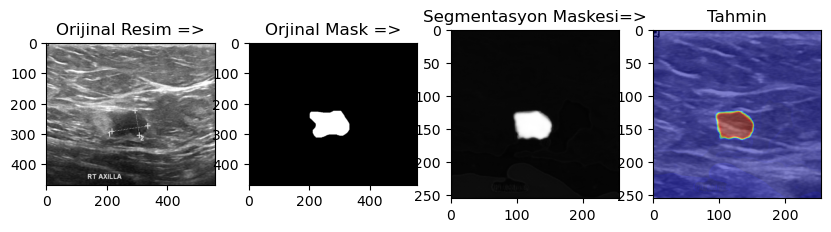

In [82]:
# Modeli kullanarak tahmin yapma
md = model(image_tensor)

# Segmentasyon sonucunu CPU'ya taşıma ve numpy dizisine dönüştürme
segmentation_output = md[0].squeeze(0).detach().cpu().numpy()  # İlk çıktı segmentasyon maskesi olmalı

import matplotlib.pyplot as plt

# Orijinal resmi ve segmentasyon sonucunu gösterme
plt.figure(figsize=(10, 5))

# Orijinal Resim
plt.subplot(1, 4, 1)
plt.imshow(Image.open(image_path))
plt.title("Orijinal Resim =>")

plt.subplot(1,4,2)
plt.imshow(Image.open(mask_path))
plt.title("Orjinal Mask =>")


# Segmentasyon Sonucu
plt.subplot(1, 4, 3)
plt.imshow(segmentation_output, cmap="gray")
plt.title("Segmentasyon Maskesi=>")

plt.subplot(1,4,4)
original_image = Image.open(image_path)
# Orijinal Resmi Gösterme
plt.imshow(original_image)

# Tahmin Edilen Maskeyi Üzerine Ekleme (transparency ile)
plt.imshow(segmentation_output, cmap="jet", alpha=0.5)  # alpha değeri transparanlık kontrolü için
plt.title("Tahmin")



plt.show()

In [29]:
from torch.utils.data import Dataset
from PIL import Image

In [28]:


class SegmentationDatasett(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels  # benign/malignant bilgisi
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale mask
        label = self.labels[idx]  # İyi huylu/kötü huylu etiketi

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask, label

In [30]:
import os

image_dir = "/Users/mehdiarat/Downloads/Dataset_BUSI_with_GT 2"  # Verilerin bulunduğu ana klasör
categories = ["benign", "malignant", "normal"]

image_paths = []
mask_paths = []
labels = []

for category in categories:
    category_image_dir = os.path.join(image_dir, category)
    label = 1 if category == "malignant" else 0  # malignant -> 1, benign -> 0 olarak kodluyoruz
    for file_name in os.listdir(category_image_dir):
        if "mask" in file_name:
            continue
        image_paths.append(os.path.join(category_image_dir, file_name))
        mask_name = file_name.replace(".png", "_mask.png")
        mask_paths.append(os.path.join(category_image_dir, mask_name))
        labels.append(label)

In [32]:
from sklearn.model_selection import train_test_split

# Verileri eğitim ve doğrulama olarak böl
train_images, val_images, train_masks, val_masks, train_labels, val_labels = train_test_split(
    image_paths, mask_paths, labels, test_size=0.2, random_state=42
)

# Dataset sınıflarını oluşturma
train_dataset = SegmentationDatasett(train_images, train_masks, train_labels, transform=transform)
val_dataset = SegmentationDatasett(val_images, val_masks, val_labels, transform=transform)

# DataLoader ile veri yükleyicileri oluşturun
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class UNetWithClassifier(nn.Module):
    def __init__(self, in_channels, out_channels, init_features=16, dropout_rate=0.1):
        super(UNetWithClassifier, self).__init__()
        
        # U-Net encoder ve decoder yapısı
        self.unet = UNet(in_channels, out_channels, init_features, dropout_rate)
        
        # Sınıflandırma için ek bir katman (bottleneck sonrası)
        self.classifier = nn.Sequential(
            nn.Linear(init_features * 16 * 32 * 32, 64),  # Flatten edilmiş bottleneck çıkış boyutu
            nn.ReLU(),
            nn.Linear(64, 1),  # İkili sınıflandırma (benign/malignant)
            nn.Sigmoid()  # 0 ile 1 arasında çıktı üretir
        )

    def forward(self, x):
        # Segmentasyon sonucu
        segmentation_output = self.unet(x)
        
        # Sınıflandırma sonucu için segmentasyon çıktısını küçült
        bottleneck_output = F.adaptive_avg_pool2d(segmentation_output, (32, 32))
        bottleneck_output = torch.flatten(bottleneck_output, start_dim=1)
        classification_output = self.classifier(bottleneck_output)
        
        return segmentation_output, classification_output

In [40]:
# Cihazı tanımlama (CPU veya GPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Modeli ve tensörleri cihaza taşıma
model = UNetWithClassifier(in_channels=3, out_channels=1).to(device)

# Örnek giriş
images = torch.randn(16, 3, 256, 256).to(device)  # Tensörü cihaza taşı
segmentation_output, classification_output = model(images)

print(segmentation_output.shape)  # Segmentasyon çıktısının şekli
print(classification_output.shape)  # Sınıflandırma çıktısının şekli

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (16x1024 and 262144x64)

In [37]:
for epoch in range(num_epochs):
    model.train()
    for images, masks, labels in train_loader:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device).float()

        optimizer.zero_grad()

        # İleri yayılım
        segmentation_output, classification_output = model(images)

        # Kayıplar: Segmentasyon ve sınıflandırma
        loss_segmentation = criterion(segmentation_output, masks)
        loss_classification = nn.BCELoss()(classification_output, labels.unsqueeze(1))  # Binary cross-entropy loss

        # Toplam kayıp
        loss = loss_segmentation + loss_classification
        loss.backward()

        optimizer.step()

ValueError: too many values to unpack (expected 2)

In [ ]:
# Eğitim veri setinden rastgele bir örnek seçelim
sample_idx = random.randint(0, len(train_dataset) - 1)
sample_image, sample_mask = train_dataset[sample_idx]

# Görüntü ve maskeyi görselleştirelim
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Görüntüyü görselleştir
ax[0].imshow(sample_image.permute(1, 2, 0))  # PyTorch (C, H, W) formatında olduğu için permute yapıyoruz
ax[0].set_title('Görüntü')
ax[0].axis('off')

# Maskeyi görselleştir
ax[1].imshow(sample_mask.squeeze(), cmap='gray')
ax[1].set_title('Maske')
ax[1].axis('off')

plt.show()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)



# Eğitim veri setinden rastgele bir örnek seçelim
sample_idx = random.randint(0, len(train_dataset) - 1)
sample_image, sample_mask = specific_dataset[sample_idx]

# Görüntü ve maskeyi görselleştirelim
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Görüntüyü görselleştir
ax[0].imshow(sample_image.permute(1, 2, 0))  # PyTorch (C, H, W) formatında olduğu için permute yapıyoruz
ax[0].set_title('Görüntü')
ax[0].axis('off')

# Maskeyi görselleştir
ax[1].imshow(sample_mask.squeeze(), cmap='gray')
ax[1].set_title('Maske')
ax[1].axis('off')

plt.show()